In [0]:
!git clone --quiet https://github.com/tensorflow/models.git

In [2]:
cd models/research

/content/models/research


In [0]:
!protoc object_detection/protos/*.proto --python_out=.

In [4]:
ls

a3c_blogpost/                      lm_commonsense/
adversarial_crypto/                lstm_object_detection/
adversarial_logit_pairing/         marco/
adversarial_text/                  maskgan/
adv_imagenet_models/               minigo/
astronet/                          morph_net/
attention_ocr/                     namignizer/
audioset/                          neural_gpu/
autoaugment/                       neural_programmer/
autoencoder/                       next_frame_prediction/
brain_coder/                       nst_blogpost/
cognitive_mapping_and_planning/    object_detection/
cognitive_planning/                pcl_rl/
compression/                       ptn/
cvt_text/                          qa_kg/
deep_contextual_bandits/           README.md
deeplab/                           real_nvp/
deep_speech/                       rebar/
delf/                              resnet/
differential_privacy/              sentiment_analysis/
domain_adaptation/                 seq2species/
effic

In [5]:
cd object_detection

/content/models/research/object_detection


In [6]:
ls

anchor_generators/                   inputs_test.py
box_coders/                          legacy/
builders/                            matchers/
CONTRIBUTING.md                      meta_architectures/
core/                                metrics/
data/                                model_hparams.py
data_decoders/                       model_lib.py
dataset_tools/                       model_lib_test.py
dockerfiles/                         model_main.py
eval_util.py                         models/
eval_util_test.py                    model_tpu_main.py
exporter.py                          object_detection_tutorial.ipynb
exporter_test.py                     predictors/
export_inference_graph.py            protos/
export_tflite_ssd_graph_lib.py       README.md
export_tflite_ssd_graph_lib_test.py  samples/
export_tflite_ssd_graph.py           test_ckpt/
g3doc/                               test_data/
inference/                           test_images/
__init__.py                          util

In [0]:
!export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim

In [8]:
ls

anchor_generators/                   inputs_test.py
box_coders/                          legacy/
builders/                            matchers/
CONTRIBUTING.md                      meta_architectures/
core/                                metrics/
data/                                model_hparams.py
data_decoders/                       model_lib.py
dataset_tools/                       model_lib_test.py
dockerfiles/                         model_main.py
eval_util.py                         models/
eval_util_test.py                    model_tpu_main.py
exporter.py                          object_detection_tutorial.ipynb
exporter_test.py                     predictors/
export_inference_graph.py            protos/
export_tflite_ssd_graph_lib.py       README.md
export_tflite_ssd_graph_lib_test.py  samples/
export_tflite_ssd_graph.py           test_ckpt/
g3doc/                               test_data/
inference/                           test_images/
__init__.py                          util

In [9]:
%set_env PYTHONPATH=/content/models/research/content/models/research/slim

env: PYTHONPATH=/content/models/research/content/models/research/slim


In [10]:
cd object_detection

[Errno 2] No such file or directory: 'object_detection'
/content/models/research/object_detection


In [11]:
ls ../../..

models/  sample_data/


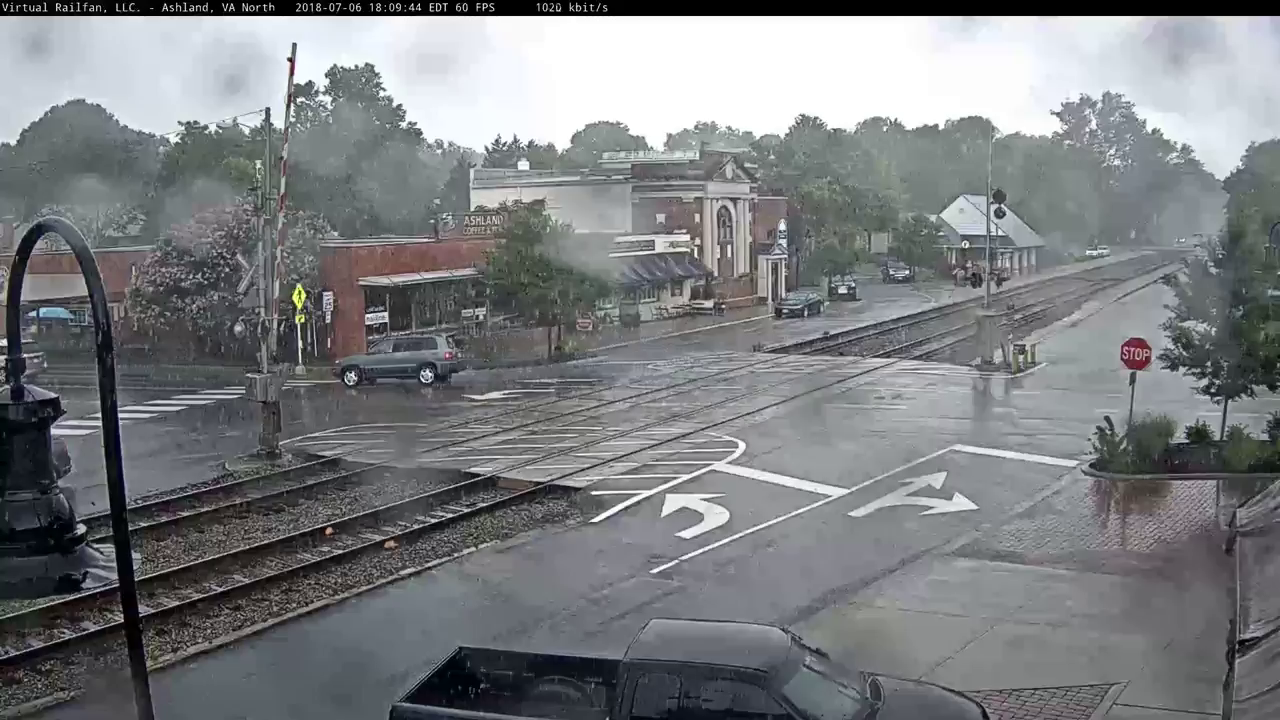

In [0]:
import cv2
import numpy as np
import PIL
from IPython.display import display

def cv2_imshow(a):
  """A replacement for cv2.imshow() for use in Jupyter notebooks."""
  a = a.clip(0, 255).astype('uint8')
  # cv2 stores colors as BGR; convert to RGB
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display(PIL.Image.fromarray(a))
  
  
cap = cv2.VideoCapture('../../../video1.mp4')
ret,img = cap.read()
cv2_imshow(img)

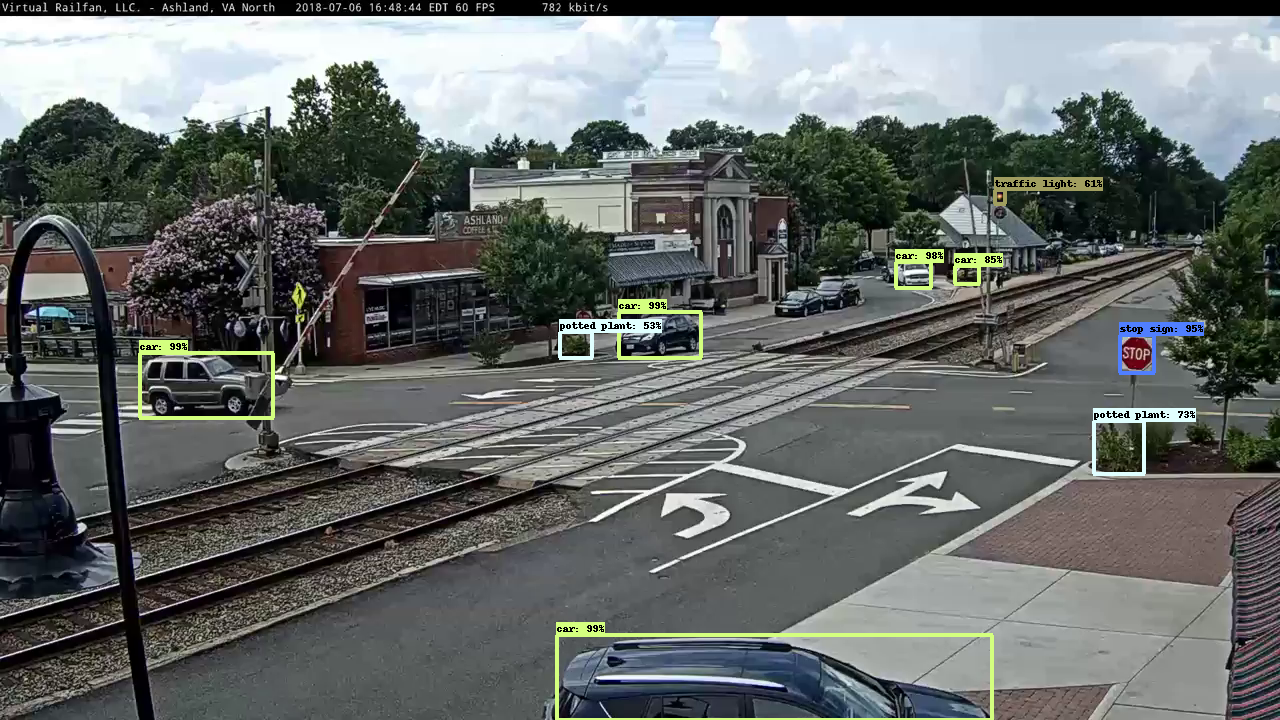

In [0]:

# coding: utf-8

# # Object Detection Demo
# Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# # Imports

# In[ ]:


import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import PIL
from IPython.display import display

import cv2

def cv2_imshow(a):
  """A replacement for cv2.imshow() for use in Jupyter notebooks."""
  a = a.clip(0, 255).astype('uint8')
  # cv2 stores colors as BGR; convert to RGB
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display(PIL.Image.fromarray(a))

  
  
cap = cv2.VideoCapture('../../../video2.mp4')

fourcc = cv2.VideoWriter_fourcc(*'DIVX')
#Specifies the parameters of the outpur video
video = cv2.VideoWriter('vid-mod.avi',fourcc,cap.get(cv2.CAP_PROP_FPS),(int(cap.get(3)), int(cap.get(4))))





# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')


# ## Env setup

# ## Object detection imports
# Here are the imports from the object detection module.

# In[ ]:


from utils import label_map_util

from utils import visualization_utils as vis_util


# # Model preparation

# ## Variables
#
# Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.
#
# By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

# In[ ]:


# What model to download.
MODEL_NAME = 'faster_rcnn_nas_coco_2018_01_28'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')


# ## Download Model

# In[ ]:


opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())


# ## Load a (frozen) Tensorflow model into memory.

# In[ ]:


detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')


# ## Loading label map
# Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

# In[ ]:


category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)


# ## Helper code

# In[ ]:


def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)


# # Detection

# In[ ]:


# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


# In[ ]:


def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict


# In[ ]:


while True:
  ret, image_np = cap.read()
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=4)
  cv2_imshow(image_np)
  video.write(image_np)
  if cv2.waitKey(1) and 0xFF == ord('q'):
      cv2.destroyAllWindows()
      break

cap.release()
video.release()
cv2.destroyAllWindows()